Checkpoint from model_18  
prev model: model_18

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, RandomHorizontalFlip, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm
from hack_train import predict

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 98 * len(GPUs)
LR = 5e-4
NUM_WORKERS = 24
MODEL_NAME = 'model_19'

In [5]:
CHECKPOINT_MODEL_NAME = 'model_18'

In [6]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in stqdm(loader, total=len(loader), desc="training...", leave=True):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [8]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in stqdm(loader, total=len(loader), desc="validation...", leave=True):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [9]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
#     RandomHorizontalFlip(0.5),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
    TransformByKeys(transforms.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3)), ("image",)),
])

In [10]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
])

In [11]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), test_transforms, split="val")

Total lines (without header): 393930
Loading train dataset (315144 lines)



Total lines (without header): 393930
Loading val dataset (78786 lines)


In [12]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                 shuffle=False, drop_last=False)

In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [16]:
model = models.resnext101_32x8d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model = nn.DataParallel(model, device_ids=GPUs)
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [17]:
with open(os.path.join(DATA_DIR, f"{CHECKPOINT_MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [18]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
loss_fn = fnn.mse_loss

In [19]:
N_EPOCHS = 100
best_val_loss = np.inf
for epoch in stqdm(range(N_EPOCHS), total=N_EPOCHS, desc="Epoch"):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    lr_scheduler.step(val_loss)
    print("Epoch #{:2}:\ttrain loss: {:.5f}\tval loss: {:.5f}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

Epoch # 0:	train loss: 2.43700	val loss: 2.12010


Epoch # 1:	train loss: 2.11981	val loss: 4.11413


Epoch # 2:	train loss: 2.12862	val loss: 1.79544


Epoch # 3:	train loss: 1.79668	val loss: 1.76876


Epoch # 4:	train loss: 1.67353	val loss: 1.72750


Epoch # 5:	train loss: 1.62338	val loss: 1.71025


Epoch # 6:	train loss: 1.55164	val loss: 1.72644


Epoch # 7:	train loss: 1.46954	val loss: 1.65946


Epoch # 8:	train loss: 1.55037	val loss: 1.67748


Epoch # 9:	train loss: 1.41009	val loss: 1.63551


Epoch #10:	train loss: 1.31179	val loss: 1.69076


Epoch #11:	train loss: 1.26812	val loss: 1.56052


Epoch #12:	train loss: 1.20625	val loss: 1.62197


Epoch #13:	train loss: 1.16469	val loss: 1.54605


Epoch #14:	train loss: 1.13766	val loss: 1.54716


Epoch #15:	train loss: 1.11130	val loss: 1.54036


Epoch #16:	train loss: 1.07657	val loss: 1.54353


Epoch #17:	train loss: 1.04148	val loss: 1.52500


KeyboardInterrupt: 

In [20]:
f'Best validation loss: {best_val_loss}'

'Best validation loss: 1.5249991089995227'

In [21]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0.01
)

In [22]:
lr_scheduler.state_dict()

{'factor': 0.5,
 'min_lrs': [0],
 'patience': 1,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0001,
 'threshold_mode': 'rel',
 'best': 1.5249991089995227,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 18,
 '_last_lr': [0.0005]}

In [23]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [24]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), test_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                  shuffle=False, drop_last=False)

Total lines (without header): 99819


In [25]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

In [26]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit_val_loss_{best_val_loss:.5f}.csv"))

In [27]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [28]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [29]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


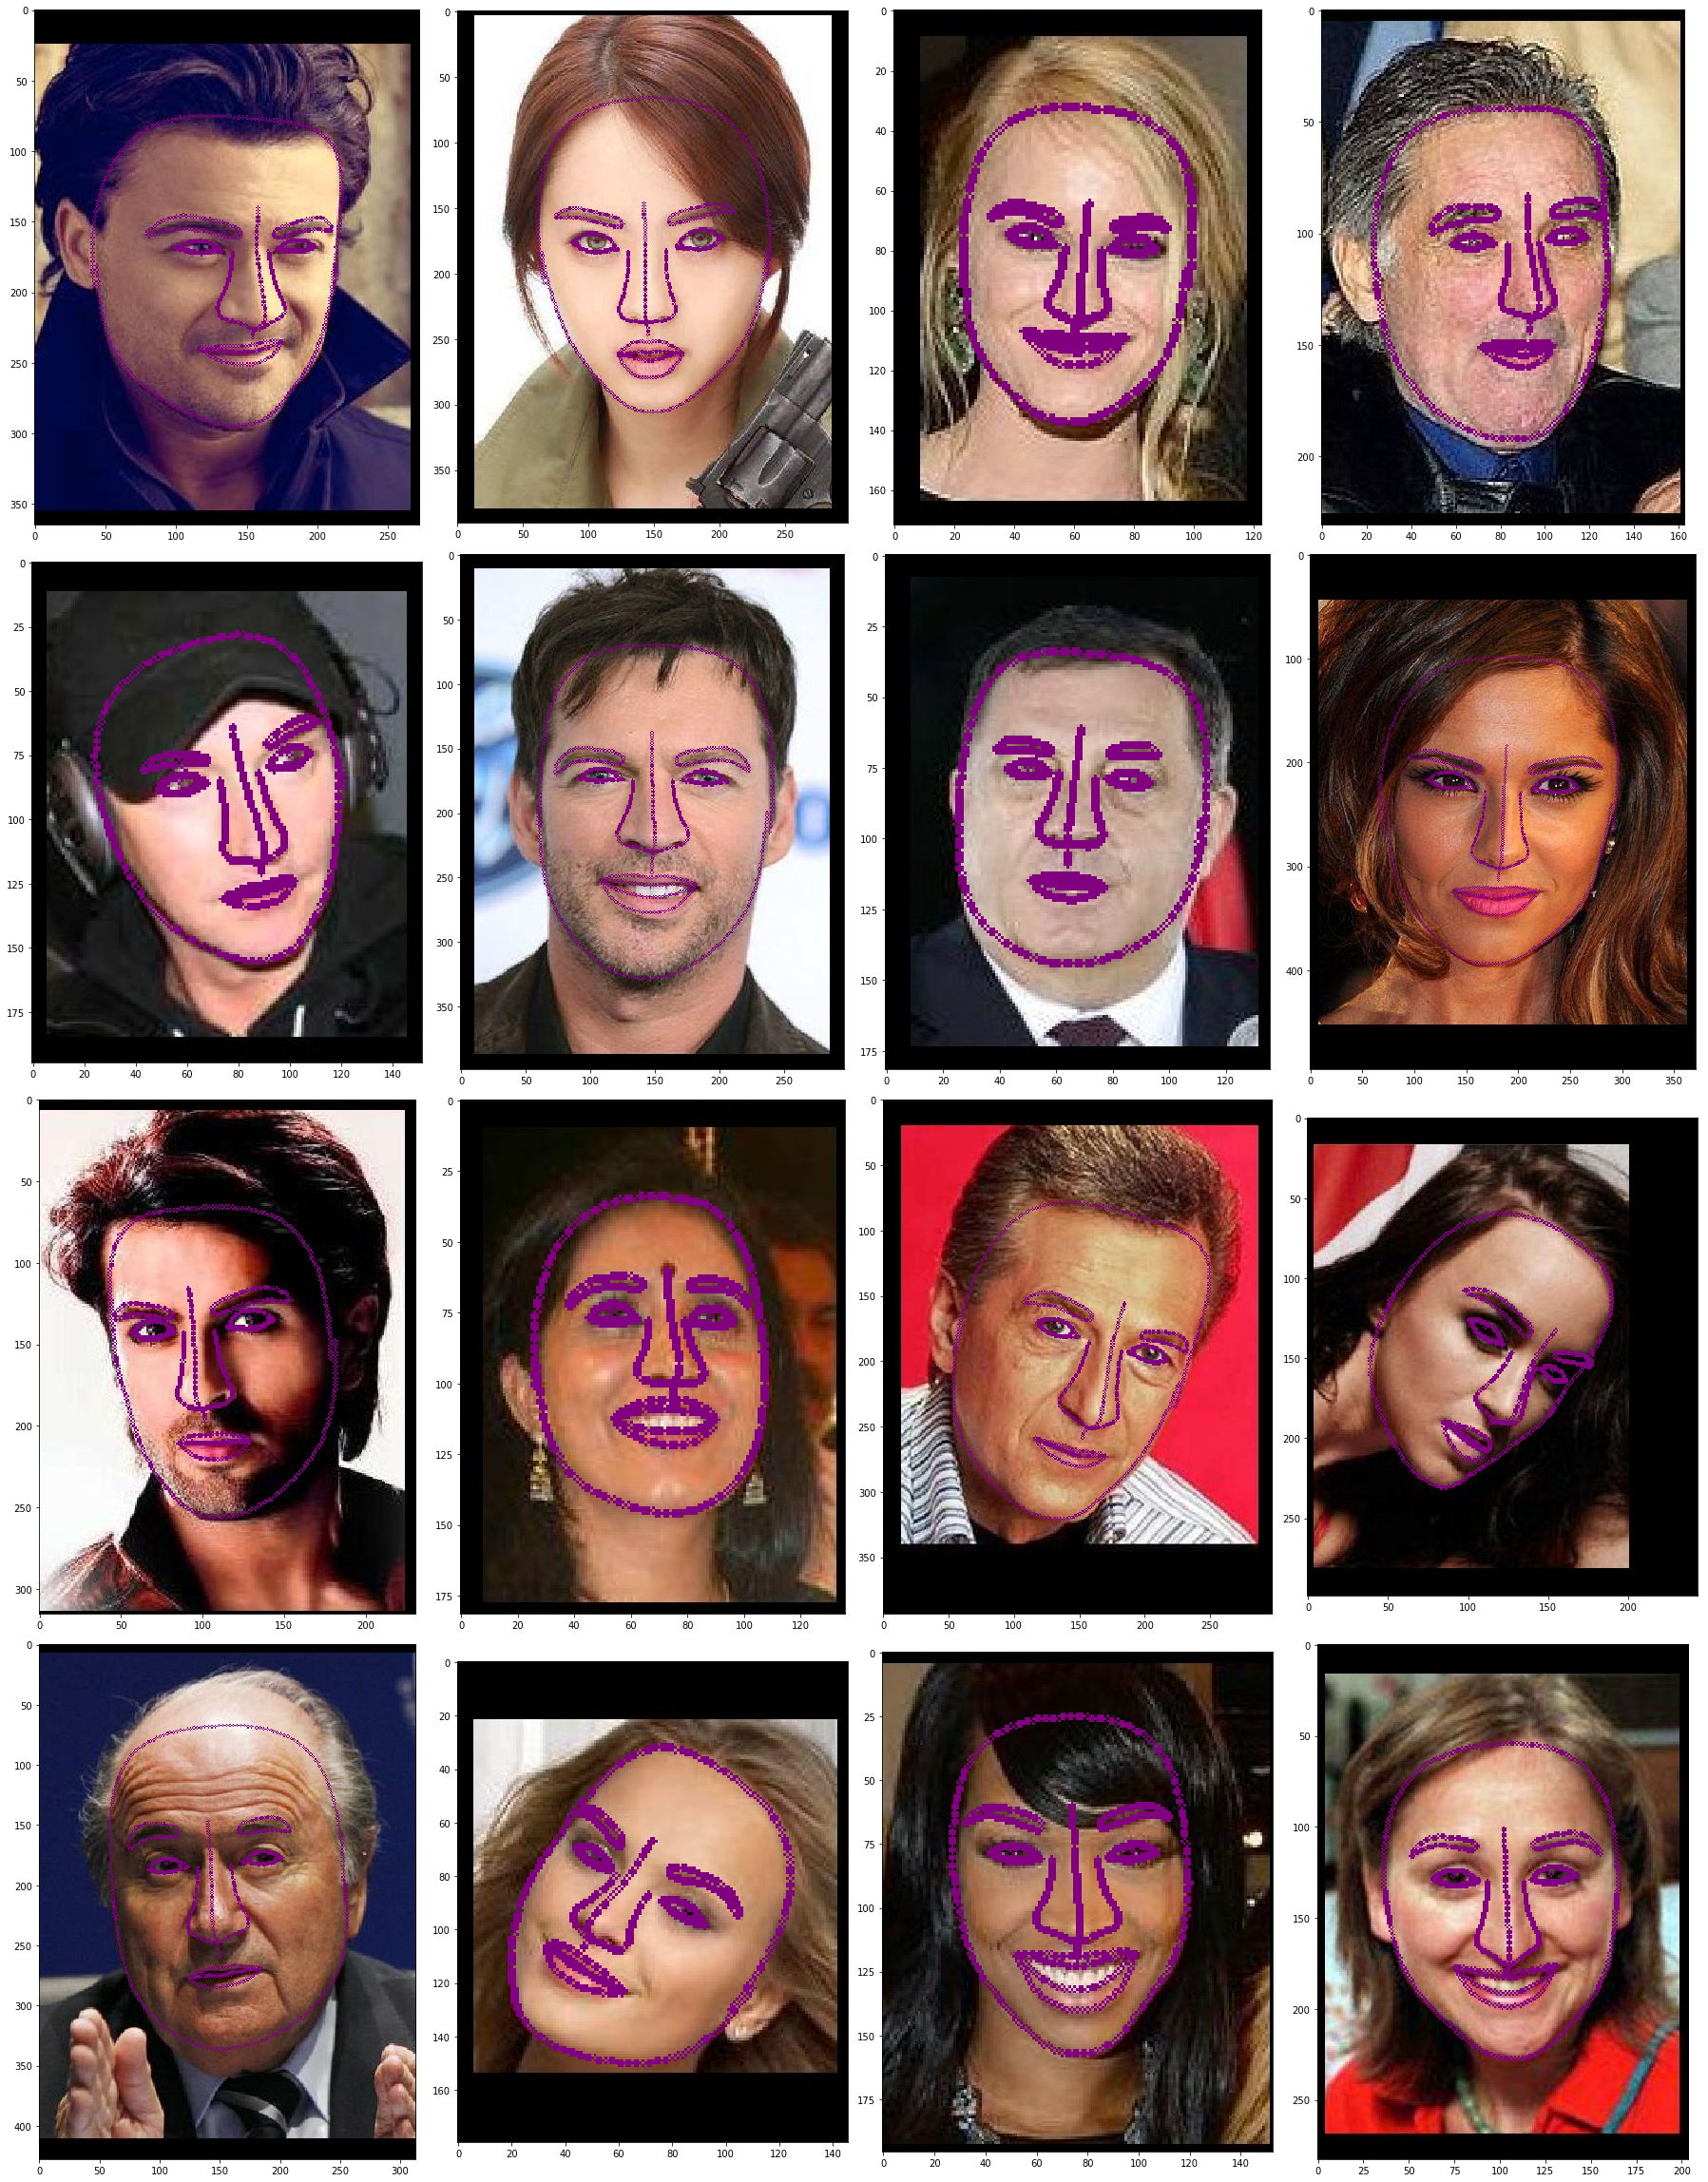

In [30]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()